<a href="https://colab.research.google.com/github/khataei/PE-classification-DeepLearning/blob/master/Tunned-1-CNN-activity-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Activity Classifier

In this notebook, we build a CNN neural net to classify PE activity.

#### Load dependencies

In [28]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint 
import os  
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


import kerastuner as kt
import IPython

#### Set hyperparameters

In [18]:
# output directory name:
output_dir = 'model_output/cnn2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency

# pooling layer parameters
maxpooling_pool_size = 2
avepooling_pool_size = 2


# convolutional layer architecture:
n_conv_1 = 256 # filters, a.k.a. kernels
k_conv_1 = 3 # kernel length
n_conv_2 = 256
k_conv_2 = 3 # kernel length
n_conv_3 = 256 # filters, a.k.a. kernels
k_conv_3 = 2 # kernel length

# dense layer architecture: 
n_dense_1 = 512
dropout_1 = 0.3
n_dense_2 = 256
dropout_2 = 0.25

# training:
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [19]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [20]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [21]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
labels_array_int

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note: to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [22]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
y.shape

(64754, 6)

In [23]:
input_shape = list(accel_array.shape)
input_shape

[64754, 90, 3]

### Splitting and shuffeling the data

In [48]:
# split and shuffle
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [127]:
# a conv model!

model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation='relu', input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation='relu'))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation='relu'))
# model.add(GlobalMaxPooling1D())
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense_1, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation='relu'))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 44, 256)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d_8 (Average (None, 21, 256)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d_10  (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)             

#### Configure model

In [129]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [130]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [131]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [132]:
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

# model.fit(x_train, y_train, 
#           batch_size=batch_size, epochs=epochs, verbose=1, 
#           validation_data=(x_valid, y_valid))

Epoch 1/60
228/228 [==============================] - 6s 25ms/step - loss: 1.0732 - accuracy: 0.5505 - val_loss: 0.8005 - val_accuracy: 0.6805
Epoch 2/60
228/228 [==============================] - 5s 23ms/step - loss: 0.7005 - accuracy: 0.7145 - val_loss: 0.5832 - val_accuracy: 0.7648
Epoch 3/60
228/228 [==============================] - 5s 23ms/step - loss: 0.4800 - accuracy: 0.8212 - val_loss: 0.6195 - val_accuracy: 0.7773
Epoch 4/60
228/228 [==============================] - 5s 23ms/step - loss: 0.3663 - accuracy: 0.8636 - val_loss: 0.3177 - val_accuracy: 0.8885
Epoch 5/60
228/228 [==============================] - 5s 23ms/step - loss: 0.3118 - accuracy: 0.8855 - val_loss: 0.2939 - val_accuracy: 0.8931
Epoch 6/60
228/228 [==============================] - 5s 23ms/step - loss: 0.2833 - accuracy: 0.8956 - val_loss: 0.3149 - val_accuracy: 0.8792
Epoch 7/60
228/228 [==============================] - 5s 23ms/step - loss: 0.2762 - accuracy: 0.9000 - val_loss: 0.2445 - val_accuracy: 0.9070

Epoch 58/60
228/228 [==============================] - 5s 23ms/step - loss: 0.0781 - accuracy: 0.9705 - val_loss: 0.1600 - val_accuracy: 0.9575
Epoch 59/60
228/228 [==============================] - 5s 23ms/step - loss: 0.0762 - accuracy: 0.9711 - val_loss: 0.1673 - val_accuracy: 0.9541
Epoch 60/60
228/228 [==============================] - 5s 24ms/step - loss: 0.0720 - accuracy: 0.9727 - val_loss: 0.1595 - val_accuracy: 0.9594


#### Evaluate

In [149]:
model.load_weights(output_dir+"/weights.49.hdf5") # 96.19 val accuracy

In [150]:
y_hat = model.predict(X_valid)

In [151]:
len(y_hat)

6476

In [152]:
y_hat[0]

array([3.2657222e-03, 1.1235670e-08, 2.5627809e-09, 1.4760160e-09,
       1.3126909e-05, 9.9672121e-01], dtype=float32)

In [153]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

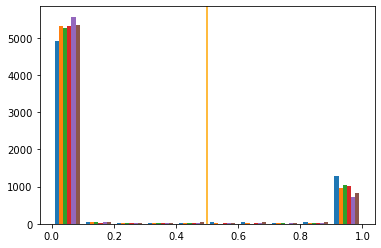

In [154]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [155]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [156]:
"{:0.2f}".format(pct_auc)

'99.79'

In [172]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [173]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [174]:
ydf.head(10)

,y_hat,y
0,"[0.003, 0.0, 0.0, 0.0, 0.0, 0.997]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.003, 0.0, 0.0, 0.0, 0.0, 0.997]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.002, 0.998, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


## Tuning process

Using `for` loops and `checkpoints` to exhaustively search for the best hyperparameters is very time consuming. Therefore, we use the `keras-tuner` module to randomly search for the best model.

In [3]:
#hyperparams to tune

layers_number = [2, 3]

# pooling layer parameters
maxpooling_pool_size = [2, 4, 8]
avepooling_pool_size = [2, 4, 8]


# convolutional layer architecture:
n_conv_1 = [128, 256, 512] # filters, a.k.a. kernels
k_conv_1 = [3, 5, 7] # kernel length
n_conv_2 = [128, 256, 512]
k_conv_2 = [3, 5, 7] # kernel length
n_conv_3 = [128, 256, 512] # filters, a.k.a. kernels
k_conv_3 = [3, 5, 7] # kernel length

# dense layer architecture: 
n_dense_1 = [256, 512, 1024]
dropout_1 = [0.2, 0.3, 0.4]
n_dense_2 = [256, 512, 1024]
dropout_2 = [0.2, 0.3, 0.4]

# training:
epochs = 60
batch_size = [256, 128]
2*3*3*3*3*3*3*3*3*3*3*3*3*2, "models to train!"

(2125764, 'models to train!')

In [54]:
# define kerastuner hyper parameters
kt_max_pooling = hp.Int('maxpooling', min_value=2, max_value=10, step=2)
kt_ave_pooling = hp.Int('avepooling', min_value=2, max_value=10, step=2)
kt_n_conv_1 = hp.Int('n_conv_1', min_value = 128, max_value= 1024, step = 256)
kt_k_conv_1 = hp.Int('k_conv_1', min_value = 2, max_value= 10, step = 2)
kt_n_conv_2 = hp.Int('n_conv_2', min_value = 128, max_value= 1024, step = 256)
kt_k_conv_2 = hp.Int('k_conv_2', min_value = 2, max_value= 10, step = 2)
kt_n_conv_3 = hp.Int('n_conv_3', min_value = 128, max_value= 1024, step = 256)
kt_k_conv_3 = hp.Int('k_conv_3', min_value = 2, max_value= 10, step = 2)
kt_activation = hp.Choice('activation', values = ['relu','elu'])
kt_n_dense_1 = hp.Int('n_dense_1', min_value = 128, max_value= 1024, step = 256)
kt_dropout_1 = hp.Choice('dropout_1', values= [0.2, 0.3, 0.4])
kt_n_dense_2 = hp.Int('n_dense_2', min_value = 128, max_value= 1024, step = 256)
kt_dropout_2 = hp.Choice('dropout_2', values= [0.2, 0.3, 0.4, 0.5])
kt_batch_size = hp.Choice('batch_size', values= [128, 256])
kt_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
kt_optimizer = hp.Choice('optimizer', values=['adam', 'nadam'])
tunning_dir = 'tunning-dir'
if not os.path.exists(tunning_dir):
    os.makedirs(tunning_dir)

In [65]:
def build_model(hp):
    model = Sequential()
    #
    model.add(Conv1D(kt_n_conv_1, kt_k_conv_1, activation=kt_activation, input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = kt_max_pooling))
    model.add(Conv1D(kt_n_conv_2, kt_k_conv_2, activation=kt_activation))
    model.add(AveragePooling1D(pool_size = kt_ave_pooling))
    model.add(Conv1D(kt_n_conv_3, kt_k_conv_3, activation=kt_activation))
    # model.add(GlobalMaxPooling1D())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(kt_n_dense_1, kt_activation))
    model.add(Dropout(kt_dropout_1))
    model.add(Dense(kt_n_dense_2, kt_activation))
    model.add(Dropout(kt_dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=kt_optimizer,
                  metrics=['accuracy'])
    return model

In [70]:
tuner = kt.RandomSearch(build_model,
                        objective = 'val_accuracy', 
                        max_trials = 1,
                        directory = tunning_dir,
                        project_name = 'CNN_tunning') 

modelcheckpoint = ModelCheckpoint(filepath=tunning_dir, save_best_only=True)

INFO:tensorflow:Reloading Oracle from existing project tunning-dir\CNN_tunning\oracle.json


In [71]:
tuner.search_space_summary()


In [68]:
tuner.search(X_train, y_train, epochs = epochs, validation_data = (X_valid, y_valid),
            callbacks=[modelcheckpoint])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 2)[0]
best_model = tuner.get_best_models(1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Epoch 1/60
1822/1822 [==============================] - ETA: 0s - loss: 1.7849 - accuracy: 0.28 - ETA: 7s - loss: 1.7705 - accuracy: 0.27 - ETA: 7s - loss: 1.7326 - accuracy: 0.28 - ETA: 7s - loss: 1.6625 - accuracy: 0.30 - ETA: 6s - loss: 1.5765 - accuracy: 0.33 - ETA: 6s - loss: 1.5203 - accuracy: 0.35 - ETA: 6s - loss: 1.4885 - accuracy: 0.36 - ETA: 6s - loss: 1.4560 - accuracy: 0.38 - ETA: 6s - loss: 1.4239 - accuracy: 0.39 - ETA: 6s - loss: 1.4084 - accuracy: 0.39 - ETA: 6s - loss: 1.3898 - accuracy: 0.40 - ETA: 6s - loss: 1.3666 - accuracy: 0.41 - ETA: 6s - loss: 1.3533 - accuracy: 0.42 - ETA: 6s - loss: 1.3326 - accuracy: 0.43 - ETA: 6s - loss: 1.3192 - accuracy: 0.43 - ETA: 6s - loss: 1.3090 - accuracy: 0.44 - ETA: 6s - loss: 1.2938 - accuracy: 0.44 - ETA: 5s - loss: 1.2852 - accuracy: 0.45 - ETA: 5s - loss: 1.2739 - accuracy: 0.45 - ETA: 5s - loss: 1.2669 - accuracy: 0.46 - ETA: 5s - loss: 1.2546 - accuracy: 0.46 - ETA: 5s - loss: 1.2444 - accuracy: 0.46 - ETA: 5s - loss: 1.23

1573/1822 [========================>.....] - ETA: 0s - loss: 0.5868 - accuracy: 0.71 - ETA: 6s - loss: 0.5327 - accuracy: 0.77 - ETA: 6s - loss: 0.4993 - accuracy: 0.79 - ETA: 6s - loss: 0.4886 - accuracy: 0.80 - ETA: 6s - loss: 0.4872 - accuracy: 0.80 - ETA: 6s - loss: 0.4839 - accuracy: 0.80 - ETA: 6s - loss: 0.4701 - accuracy: 0.81 - ETA: 6s - loss: 0.4784 - accuracy: 0.81 - ETA: 6s - loss: 0.4744 - accuracy: 0.81 - ETA: 6s - loss: 0.4738 - accuracy: 0.81 - ETA: 6s - loss: 0.4711 - accuracy: 0.81 - ETA: 6s - loss: 0.4658 - accuracy: 0.81 - ETA: 6s - loss: 0.4647 - accuracy: 0.81 - ETA: 6s - loss: 0.4649 - accuracy: 0.81 - ETA: 6s - loss: 0.4625 - accuracy: 0.81 - ETA: 6s - loss: 0.4688 - accuracy: 0.81 - ETA: 5s - loss: 0.4678 - accuracy: 0.81 - ETA: 5s - loss: 0.4675 - accuracy: 0.81 - ETA: 5s - loss: 0.4664 - accuracy: 0.81 - ETA: 5s - loss: 0.4638 - accuracy: 0.81 - ETA: 5s - loss: 0.4629 - accuracy: 0.81 - ETA: 5s - loss: 0.4636 - accuracy: 0.81 - ETA: 5s - loss: 0.4656 - accura

KeyboardInterrupt: 